TF version: 2.13.0
TFP version: 0.21.0


Polynomial([-10., 100.,   6.,   5.], domain=[-1,  1], window=[-1,  1], symbol='x')

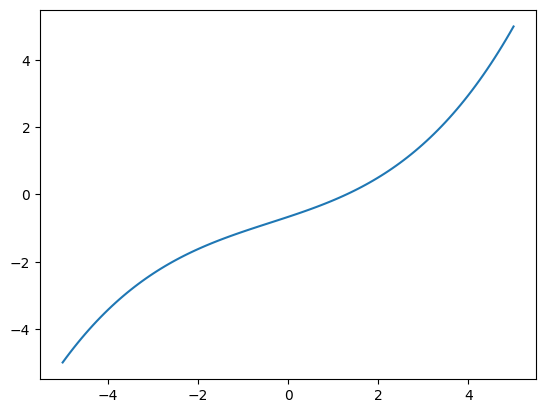

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import tqdm
tfd = tfp.distributions
tfb=tfp.bijectors
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)
import sys
sys.path.append("/home/vishal/deriv")
import deriv.BS as BS


px=np.polynomial.polynomial.Polynomial([-10,100,6,5])
lowlim=-5
uplim=-lowlim
sc=(px(uplim)-px(lowlim))/(uplim-lowlim)
sh=(px(lowlim)/sc-lowlim)

b=px.linspace(120,[lowlim,uplim])
plt.plot(b[0],b[1]/sc-sh)
#target=px.linspace(10,[-5,5])
#target[1]=target[1]/sc-sh
display(px)


In [127]:
fwd=10.05
vswap=0.2
samplesize=100000
samples=(px(np.random.normal(size=samplesize))/sc-sh)
normalize=vswap/samples.std()
samplesn=samples*normalize
bijected=np.exp(samplesn)
bijected= bijected/bijected.mean()*fwd
display(bijected.mean(),np.log(bijected).std())
bijected
botransform=np.exp((b[1]/sc-sh)*normalize)


10.050000000000006

0.19999999999999998

In [138]:
(np.log(fwd)+0.5*vswap*vswap).astype(np.float32)

2.3275726

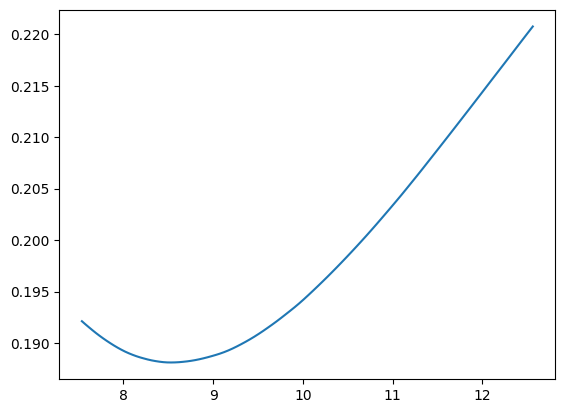

In [129]:
strikes=np.geomspace(0.75,1.25,num=100)*fwd
vols=[]
for k in strikes:
    vols.append(BS.volfromsim(bijected, fwd, k, 1.0))
vols=np.array(vols)
plt.plot(strikes,vols)

In [130]:
bins=10
bincor=px.linspace(bins+1,[lowlim,uplim])

bw=np.diff(bincor[0]).astype(np.float32)
bh=np.diff(bincor[1]/sc-sh).astype(np.float32)
pdash=px.deriv()
ks=(pdash(bincor[0])/sc).astype(np.float32)
bw.shape,bh.shape,ks.shape

((10,), (10,), (11,))

In [131]:
eurusd=tf.convert_to_tensor(bijected,dtype=np.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=7.453962>

<tf.Tensor: shape=(), dtype=float32, numpy=2.7420259>

<Axes: ylabel='Count'>

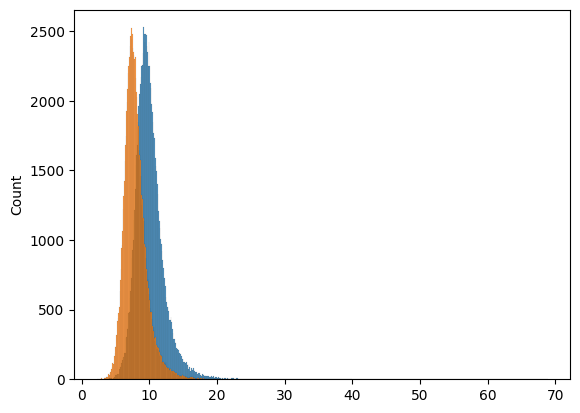

In [132]:
exp_bijector = tfb.Exp()
#scale_bijector=tfb.Scale(scale=tf.Variable(fwd*tf.exp(-sigma*sigma*T/2),name="scale1"))
#scale_bijector1=tfb.Scale(scale=tf.Variable(sigma*tf.math.sqrt(T),name="scale2"))                         

scale_bijector=tfb.Scale(scale=tf.Variable(vswap*2,name="scale1"))
#scale_bijector1=tfb.Scale(scale=tf.Variable(vswap,name="scale2")) 
shift_bijector=tfb.Shift(shift=tf.Variable((np.log(fwd)).astype(np.float32),name="shift1")) 

logit_low=tf.Variable(-1.0,name="logit_low")
logit_high=tf.Variable(1.0,name="logit_high")
sig_low=tf.Variable(-1.0,name="sig_low")
sig_high=tf.Variable(1.0,name="sig_high")

bin_widths=tf.constant(bw,name="xwidth")
bin_heights=tf.constant(bh,name="ywidth")
knot_slopes=tf.constant(ks[1:-1],name="knotspaces")


logit_bijector=tfb.Invert(tfb.Sigmoid(low=logit_low,high=logit_high))
sig_bijector=tfb.Invert(tfb.Sigmoid(low=sig_low,high=sig_high))
spline_bijector=tfb.RationalQuadraticSpline(
    bin_widths,
    bin_heights,
    knot_slopes,
    range_min=-5,
    validate_args=True,
    name=None
)


#bijec = tfb.Chain([scale_bijector,exp_bijector,scale_bijector1,logit_bijector])
#bijec = tfb.Chain([scale_bijector,sig_bijector,exp_bijector,shift_bijector,scale_bijector1,logit_bijector])
#bijec = tfb.Chain([scale_bijector,exp_bijector,shift_bijector,scale_bijector1])
#bijec = tfb.Chain([scale_bijector,exp_bijector,shift_bijector,scale_bijector1,logit_bijector])

bijec = tfb.Chain([exp_bijector,shift_bijector,scale_bijector,spline_bijector])

log_normal=bijec(tfd.Normal(0.0,1.0))
display(log_normal.sample())
def nll(dist, x_train):
    """Calculates the negative log-likelihood for a given distribution
    and a data set."""
    return -tf.reduce_mean(dist.log_prob(x_train))
display(nll(log_normal,bijected))
simtf=log_normal.sample(samplesize)
sns.histplot(bijected)
sns.histplot(simtf.numpy())

(<tf.Variable 'shift1:0' shape=() dtype=float32, numpy=2.5355077>,
 <tf.Variable 'scale1:0' shape=() dtype=float32, numpy=0.38786983>)

1

10.051968

0.19982965

1

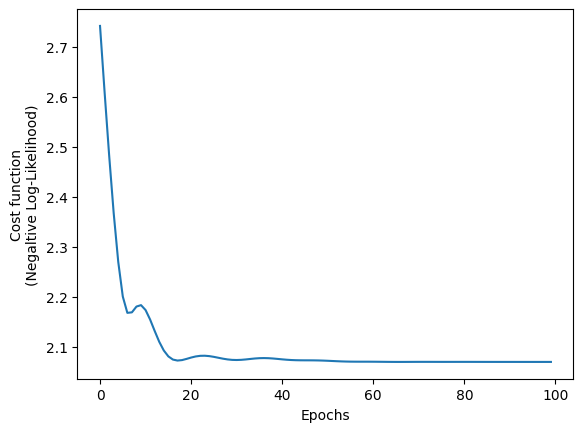

In [133]:
@tf.function
def get_loss_and_grads(dist, x_train):
    with tf.GradientTape() as tape:
        tape.watch(dist.trainable_variables)
        loss = nll(dist, x_train)
        grads = tape.gradient(loss, dist.trainable_variables)
    return loss, grads

# Instantiate a stochastic gradient descent optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)



# Custom training loop
epochs = 100
nll_loss = []
for _ in range(epochs):
    loss, grads = get_loss_and_grads(log_normal, eurusd)
    optimizer.apply_gradients(zip(grads, log_normal.trainable_variables))
    nll_loss.append(loss)
 
plt.plot(nll_loss)
plt.xlabel('Epochs')
plt.ylabel('Cost function\n(Negaltive Log-Likelihood)');
display(log_normal.trainable_variables)
simtf=log_normal.sample(samplesize)
display(1,simtf.numpy().mean(),np.log(simtf.numpy()).std(),1)

<Axes: ylabel='Count'>

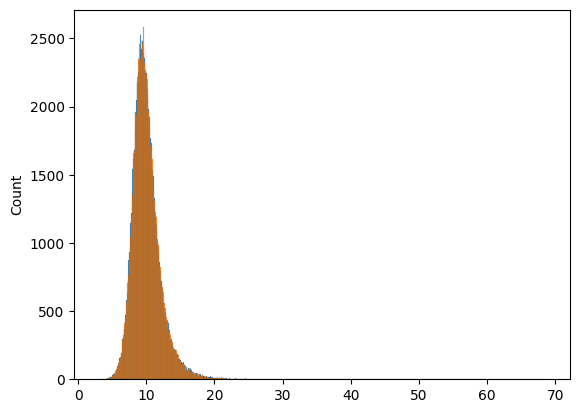

In [134]:
sns.histplot(bijected)
sns.histplot(simtf.numpy())

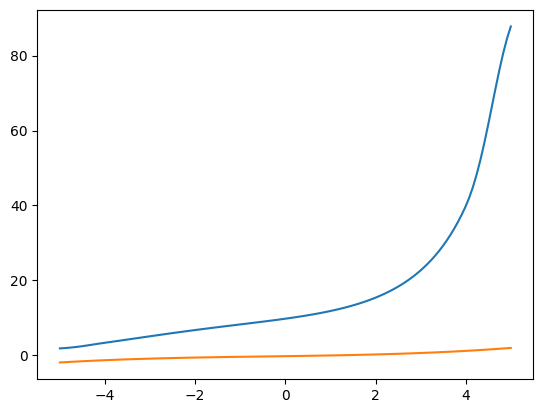

In [135]:
plt.plot(b[0],bijec(b[0]))
plt.plot(b[0],np.log(botransform))

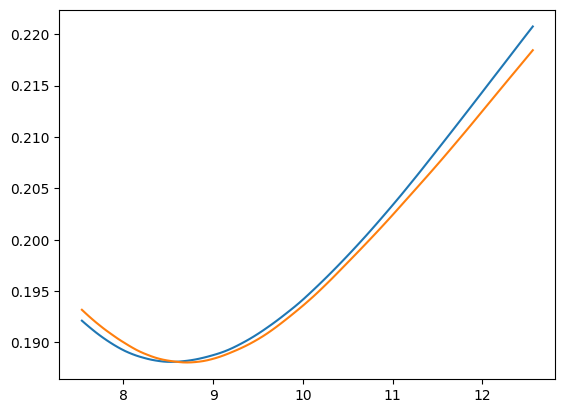

In [136]:
strikes=np.geomspace(0.75,1.25,num=100)*fwd
vols=[]
volcalib=[]
for k in strikes:
    vols.append(BS.volfromsim(bijected, fwd, k, 1.0))
    volcalib.append(BS.volfromsim(simtf.numpy(), fwd, k, 1.0))
vols=np.array(vols)
volscalib=np.array(volcalib )
plt.plot(strikes,vols)
plt.plot(strikes,volscalib)

In [137]:
#%debug